<a href="https://colab.research.google.com/github/abhinavdayal/EIP_Session3/blob/master/Attempt02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(100) 

TensorFlow 2.x selected.


Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


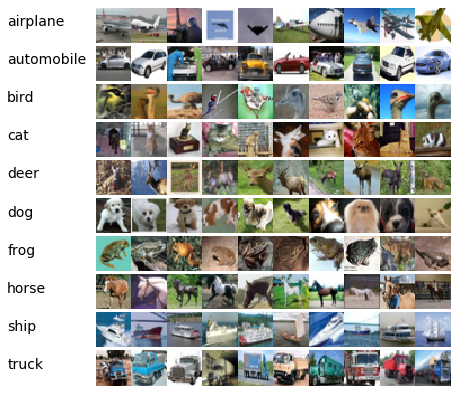

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels  =  train_features.shape
num_test, _, _, _ =  test_features.shape
labels = np.unique(train_labels)
num_classes = len(labels)
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(train_labels[:]==i)[0], 10, replace=False)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, 11):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(train_features[idx[j-1]], interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [6]:
# Define the model, Since image size is already small we wont use stride > 1.
# we have to use only separatble convolution
model = keras.Sequential()

# rin=1, nin = 32x32, cin= 3, jin=1, k=3, p=1, s=1, jout=1, rout=3, nout=32x32, cout=16
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', depth_multiplier=1, input_shape=(32, 32, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
# rin=3, nin = 32x32, cin=16, jin=1, k=3, p=1, s=1, jout=1, rout=5, nout=32x32, cout=32
model.add(SeparableConv2D(filters=48, kernel_size=(3, 3), padding='same', depth_multiplier=1, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
# rin=5, nin = 32x32, cin=32, jin=1, k=3, p=1, s=1, jout=1, rout=7, nout=32x32, cout=48
model.add(SeparableConv2D(filters=96, kernel_size=(3, 3), padding='same', depth_multiplier=1, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

# rin=7, nin = 32x32, cin=48, jin=1, k=2, p=1, s=2, jout=2, rout=8, nout=16x16, cout=48
model.add(MaxPooling2D())

# rin=8, nin = 16x16, cin= 48, jin=2, k=3, p=1, s=1, jout=2, rout=12, nout=16x16, cout=64
model.add(SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', depth_multiplier=1, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

# rin=12, nin = 16x16, cin= 64, jin=2, k=3, p=1, s=1, jout=2, rout=16, nout=16x16, cout=96
model.add(SeparableConv2D(filters=160, kernel_size=(3, 3), padding='same', depth_multiplier=1, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

# rin=16, nin = 16x16, cin=96, jin=2, k=2, p=1, s=2, jout=4, rout=18, nout=8x8, cout=96
model.add(MaxPooling2D())

# rin=18, nin = 8x8, cin= 96, jin=4, k=3, p=1, s=1, jout=4, rout=26, nout=6x6, cout=128
model.add(SeparableConv2D(filters=192, kernel_size=(3, 3), padding='valid', depth_multiplier=1, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

# rin=26, nin = 6x6, cin= 128, jin=4, k=3, p=1, s=1, jout=4, rout=34, nout=4x4, cout=10 Cfar_10 has 10 classes
model.add(SeparableConv2D(filters=num_classes, kernel_size=(3, 3), padding='valid', depth_multiplier=1, use_bias=False))
# not adding any activation or batch normalization after the last convolution layer

# output size = 1x1x10
model.add(GlobalAveragePooling2D())
model.add(Flatten()) # 10x1
model.add(Activation('softmax')) # get probabilities

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 32, 32, 32)        123       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 32, 32, 48)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 32, 32, 96)        5

Epoch 1/50
390/390 [==============================] - 65s 166ms/step - loss: 1.5066 - accuracy: 0.4520 - val_loss: 2.7693 - val_accuracy: 0.1009
Epoch 2/50
390/390 [==============================] - 62s 158ms/step - loss: 1.1571 - accuracy: 0.5862 - val_loss: 1.4282 - val_accuracy: 0.5155
Epoch 3/50
390/390 [==============================] - 61s 157ms/step - loss: 1.0201 - accuracy: 0.6390 - val_loss: 0.9466 - val_accuracy: 0.6691
Epoch 4/50
390/390 [==============================] - 61s 156ms/step - loss: 0.9393 - accuracy: 0.6704 - val_loss: 1.2638 - val_accuracy: 0.6012
Epoch 5/50
390/390 [==============================] - 61s 157ms/step - loss: 0.8734 - accuracy: 0.6946 - val_loss: 1.3478 - val_accuracy: 0.5937
Epoch 6/50
390/390 [==============================] - 61s 157ms/step - loss: 0.8220 - accuracy: 0.7126 - val_loss: 0.9507 - val_accuracy: 0.6843
Epoch 7/50
390/390 [==============================] - 61s 158ms/step - loss: 0.7864 - accuracy: 0.7256 - val_loss: 1.1812 - val_ac

KeyError: ignored

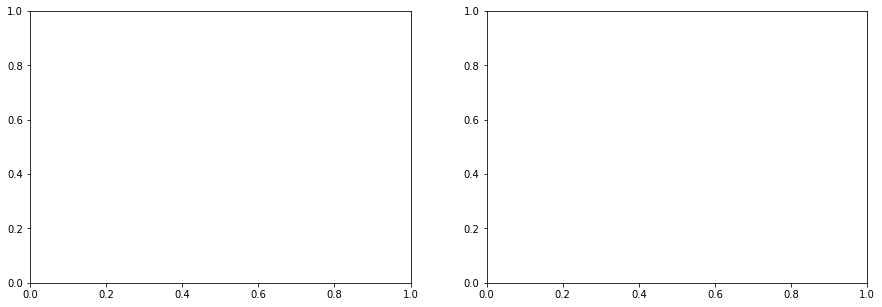

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2)

#datagen.fit(train_features)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = (train_features.shape[0]//128), epochs = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


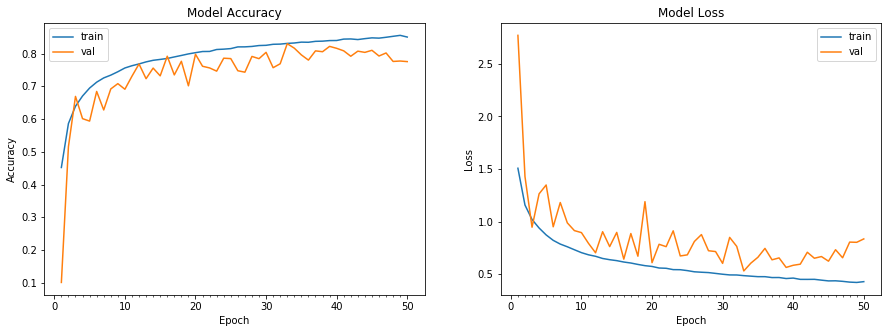

Accuracy on test data is: 77.54


In [9]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))